In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import math
from wordcloud import WordCloud
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1NH9Ll58DRdae79AxClUS7TvfhZOUyjJG'
download = drive.CreateFile({'id': file_id})

# Download the file to a local disc
download.GetContentFile('file.csv')
df = pd.read_csv('file.csv',index_col=0)

In [ ]:
df.shape

(43055, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43055 entries, 0 to 43054
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   43055 non-null  object
 1   text    43055 non-null  object
 2   target  43055 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [ ]:
# Drop 'Unnamed: 0' column. Added when read in from CSV
df.drop(columns=['title'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43055 entries, 0 to 43054
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    43055 non-null  object
 1   target  43055 non-null  object
dtypes: object(2)
memory usage: 1009.1+ KB


In [ ]:
# ---- Target feature ----
df['target'].value_counts()

Real    23362
Fake    19693
Name: target, dtype: int64

In [ ]:
unique_values = df["target"].unique()
unique_values

array(['Real', 'Fake'], dtype=object)

In [ ]:


for value in unique_values:
    if value not in ["Real", "Fake"]:
        print(f"Found an invalid value in 'target': {value}")

In [ ]:
def plot_histogram_with_percentage(df, column, height=10, width=10):
    # Convert the column to categorical type
    df[column] = df[column].astype('str')
    count = df[column].value_counts()
    percentage = count / df[column].count() * 100
    fig, ax = plt.subplots(figsize=(width, height))
    ax.bar(count.index, count.values)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    for i, p in enumerate(percentage):
        ax.text(count.index[i], count.values[i], f"{p:.2f}%")
    plt.show()

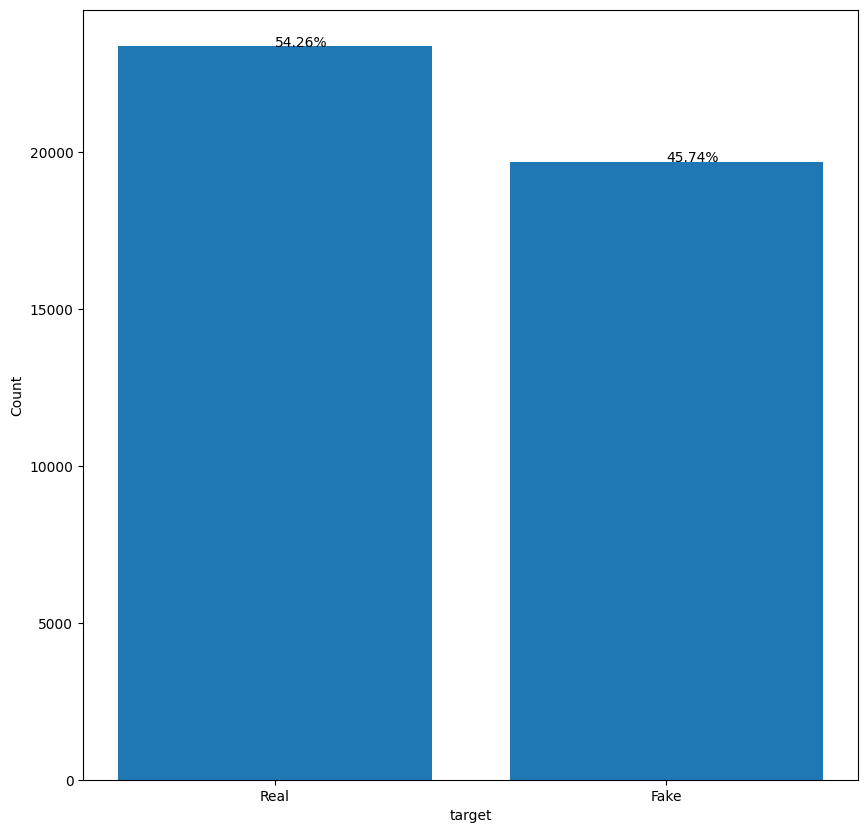

In [ ]:
plot_histogram_with_percentage(df,'target')

In [ ]:
df.head(-5)

,text,target
0,ANKARA (Reuters) - Turkish and Sudanese intell...,Real
1,(Reuters) - The U.S. Supreme Court on Friday r...,Real
2,If there s one presidential candidate who is t...,Fake
3,No wonder she didn t want anyone to see her sp...,Fake
4,Feel the Bern of a lot of gullible young peopl...,Fake
...,...,...
43045,Vice President Joe Biden has reportedly been a...,Fake
43046,She burst on the scene last August when she up...,Fake
43047,ROME (Reuters) - Rescuers pulled 700 boat migr...,Real
43048,HAVANA (Reuters) - Opponents of the Cuban gove...,Real


In [ ]:
df.text[456]

'https://www.youtube.com/watch?v=zZ7GrEItGoo'

In [ ]:
df.text[1837]

'https://www.youtube.com/watch?v=8dsDdBqF828'

In [ ]:
import copy
df_org = copy.deepcopy(df)

## Data Cleaning

In [ ]:
## Check whether the text column has URL

In [ ]:
def contains_url(text):
    url_pattern = re.compile(r'http\S+|www\.\S+')
    return bool(url_pattern.search(text))


In [ ]:
df['contains_url'] = df['text'].apply(contains_url)


In [ ]:
df_with_urls = df[df['contains_url'] == True]


In [ ]:
df_with_urls.text[413]


"Michelle Obama has scrubbed any reference to Hillary from her Twitter account What? Like with a cloth or something? LOL!Seriously though, it looks like Mooch is trying get rid of any evidence of something she posted to Twitter between March 4, 2013 and now. Hmmm wonder if it has anything to do with a certain presidential candidate s FBI investigation? Michelle Obama has scrubbed all references to Hillary Clinton from both of her Twitter accounts as news breaks that Clinton is under two different FBI investigations involving four FBI offices.Has @MichelleObama deleted her tweets for the past 3 and a half years?  Paul Joseph Watson (@PrisonPlanet) November 1, 2016Barrack Obama's Husband Michelle Scrubs Hillary Clinton From Twitter History.The tide has turned.#MAGAhttps://t.co/dmH239cdiv  General Halley   (@HalleyBorderCol) November 1, 2016The @FLOTUS account has been wiped clean of all traces of Hillary, and @MichelleObama, a verified page with almost six million followers, has been scr

In [ ]:
df_with_urls.shape


(2824, 3)

In [ ]:
count_rows_with_urls = df_with_urls.shape[0]
print(f"Number of rows containing URLs: {count_rows_with_urls}")



Number of rows containing URLs: 2824


In [ ]:
df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x))  # To remove URLs that start with 'http'


In [ ]:
df['text'] = df['text'].apply(lambda x: re.sub(r'www\.\S+', '', x))  # To remove URLs that start with 'www'

In [ ]:
df.text[413]

"Michelle Obama has scrubbed any reference to Hillary from her Twitter account What? Like with a cloth or something? LOL!Seriously though, it looks like Mooch is trying get rid of any evidence of something she posted to Twitter between March 4, 2013 and now. Hmmm wonder if it has anything to do with a certain presidential candidate s FBI investigation? Michelle Obama has scrubbed all references to Hillary Clinton from both of her Twitter accounts as news breaks that Clinton is under two different FBI investigations involving four FBI offices.Has @MichelleObama deleted her tweets for the past 3 and a half years?  Paul Joseph Watson (@PrisonPlanet) November 1, 2016Barrack Obama's Husband Michelle Scrubs Hillary Clinton From Twitter History.The tide has turned.#MAGA  General Halley   (@HalleyBorderCol) November 1, 2016The @FLOTUS account has been wiped clean of all traces of Hillary, and @MichelleObama, a verified page with almost six million followers, has been scrubbed all the way back 

In [ ]:
df

,text,target,contains_url
0,ANKARA (Reuters) - Turkish and Sudanese intell...,Real,False
1,(Reuters) - The U.S. Supreme Court on Friday r...,Real,False
2,If there s one presidential candidate who is t...,Fake,False
3,No wonder she didn t want anyone to see her sp...,Fake,False
4,Feel the Bern of a lot of gullible young peopl...,Fake,False
...,...,...,...
43050,WASHINGTON (Reuters) - Democratic presidential...,Real,False
43051,VATICAN CITY/WASHINGTON (Reuters) - U.S. Democ...,Real,False
43052,"Last week, after the New York Giants player Od...",Fake,False
43053,ALMATY (Reuters) - Kazakhstan is to change its...,Real,False


In [ ]:
df.drop(columns=['contains_url'], inplace=True)

In [ ]:
df.head(2)

,text,target
0,ANKARA (Reuters) - Turkish and Sudanese intell...,Real
1,(Reuters) - The U.S. Supreme Court on Friday r...,Real


In [ ]:
# Regular expression to match email addresses
email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'

# Check if the 'text' column contains email addresses
df['contains_email'] = df['text'].apply(lambda x: bool(re.search(email_pattern, x)))

print(df)

                                                    text target  \
0      ANKARA (Reuters) - Turkish and Sudanese intell...   Real   
1      (Reuters) - The U.S. Supreme Court on Friday r...   Real   
2      If there s one presidential candidate who is t...   Fake   
3      No wonder she didn t want anyone to see her sp...   Fake   
4      Feel the Bern of a lot of gullible young peopl...   Fake   
...                                                  ...    ...   
43050  WASHINGTON (Reuters) - Democratic presidential...   Real   
43051  VATICAN CITY/WASHINGTON (Reuters) - U.S. Democ...   Real   
43052  Last week, after the New York Giants player Od...   Fake   
43053  ALMATY (Reuters) - Kazakhstan is to change its...   Real   
43054  President Obama had scathing words for the law...   Fake   

       contains_email  
0               False  
1               False  
2               False  
3               False  
4               False  
...               ...  
43050           False  
430

In [ ]:
df.text[428]

'By John W. Whitehead\n“Today the path to total dictatorship in the U.S. can be laid by strictly legal means, unseen and unheard by Congress, the President, or the people . Outwardly we have a Constitutional government. We have operating within our government and political system … a well-organized political-action group in this country, determined to destroy our Constitution and establish a one-party state…. \nThe important point to remember about this group is not its ideology but its organization… It operates secretly, silently, continuously to transform our Government…. This group … is answerable neither to the President, the Congress, nor the courts. It is practically irremovable. ”— Senator William Jenner, 1954 speech \nUnaffected by elections. Unaltered by populist movements. Beyond the reach of the law.\nSay hello to America’s shadow government.\nA corporatized, militarized, entrenched bureaucracy that is fully operational and staffed by unelected officials who are, in essence,

In [ ]:
# Remove email address

df['text'] = df['text'].apply(lambda x: re.sub(r'\S+@\S+', '', x))

In [ ]:
df_with_email = df[df['contains_email'] == True]
df_with_email.head(2)

,text,target,contains_email
428,By John W. Whitehead\n“Today the path to total...,Fake,True
2393,**Want FOX News First in your inbox every day?...,Real,True


In [ ]:
df.text[428]

'By John W. Whitehead\n“Today the path to total dictatorship in the U.S. can be laid by strictly legal means, unseen and unheard by Congress, the President, or the people . Outwardly we have a Constitutional government. We have operating within our government and political system … a well-organized political-action group in this country, determined to destroy our Constitution and establish a one-party state…. \nThe important point to remember about this group is not its ideology but its organization… It operates secretly, silently, continuously to transform our Government…. This group … is answerable neither to the President, the Congress, nor the courts. It is practically irremovable. ”— Senator William Jenner, 1954 speech \nUnaffected by elections. Unaltered by populist movements. Beyond the reach of the law.\nSay hello to America’s shadow government.\nA corporatized, militarized, entrenched bureaucracy that is fully operational and staffed by unelected officials who are, in essence,

In [ ]:
df.drop(columns=['contains_email'], inplace=True)

In [ ]:
df.head(-5)

,text,target
0,ANKARA (Reuters) - Turkish and Sudanese intell...,Real
1,(Reuters) - The U.S. Supreme Court on Friday r...,Real
2,If there s one presidential candidate who is t...,Fake
3,No wonder she didn t want anyone to see her sp...,Fake
4,Feel the Bern of a lot of gullible young peopl...,Fake
...,...,...
43045,Vice President Joe Biden has reportedly been a...,Fake
43046,She burst on the scene last August when she up...,Fake
43047,ROME (Reuters) - Rescuers pulled 700 boat migr...,Real
43048,HAVANA (Reuters) - Opponents of the Cuban gove...,Real


In [ ]:
#### Removing HTML tags,punctuations,special characters etc using regular expressions.
TAG_RE = re.compile(r'<[^>]+>') # match anything in the tag <...>

def remove_tags(text):
    #print(text)
    return TAG_RE.sub('', text) # replace that tag with a null string

def process_text(sen):
    #print(sen)
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) # look for any character except a toz or A to Z and replace with space

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # Look for one or more space with any a-z or a-Z letter followed by multiple space and replace with a space
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence) # finally check for continuous space and replace them with a single space

    return sentence

In [ ]:
# clean text data
start = time.time()
for row in df.itertuples():
    article = process_text(str(df.loc[row.Index,'text']))
    df.loc[row.Index,'text'] = article
stop = time.time()
print(f'Cleaning took: {round((stop-start)/60, 3)} minutes')

Cleaning took: 0.328 minutes


In [ ]:
df.head(-5)

,text,target
0,ANKARA Reuters Turkish and Sudanese intelligen...,Real
1,Reuters The Supreme Court on Friday refused t...,Real
2,If there one presidential candidate who is the...,Fake
3,No wonder she didn want anyone to see her spee...,Fake
4,Feel the Bern of lot of gullible young people ...,Fake
...,...,...
43045,Vice President Joe Biden has reportedly been a...,Fake
43046,She burst on the scene last August when she up...,Fake
43047,ROME Reuters Rescuers pulled boat migrants to ...,Real
43048,HAVANA Reuters Opponents of the Cuban governme...,Real


In [ ]:
df.text[0]

'ANKARA Reuters Turkish and Sudanese intelligence agencies have captured and returned to Turkey man believed to be financier for the based cleric accused of orchestrating failed coup in Turkey the state run Anadolu news agency said on Monday Citing security sources Anadolu said Turkey MIT and Sudan NISS intelligence agencies carried out joint operation targeting Memduh Cikmaz in Sudan and returned him to Turkey early on Monday Cikmaz labelled by Turkish media money safe for the network of based cleric Fethullah Gulen is believed to have transferred millions of dollars to Gulen network from Sudan since he fled there in January Anadolu said Sudanese officials could not immediately be reached for comment Gulen is accused by Ankara of orchestrating the failed July coup against President Tayyip Erdogan He has denied any involvement Since the abortive coup more than people have been jailed pending trial over alleged links to Gulen while some people have been sacked or suspended from jobs in 

In [ ]:
len(df.text[0])

1371

# Data cleaning





In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required datasets from nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define a function for preprocessing
def preprocess_text(text):
    # Tokenize
    words = word_tokenize(text)

    # Lowercasing
    words = [word.lower() for word in words]

    # Stopwords removal
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

# Apply the preprocessing function to the 'text' column
df['text'] = df['text'].apply(preprocess_text)
print(df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                                    text target
0      ankara reuters turkish sudanese intelligence a...   Real
1      reuters supreme court friday refused stay ruli...   Real
2      one presidential candidate king dog whistle po...   Fake
3      wonder want anyone see speech singing praise t...   Fake
4      feel bern lot gullible young people fed big li...   Fake
...                                                  ...    ...
43050  washington reuters democratic presidential nom...   Real
43051  vatican city washington reuters democratic pre...   Real
43052  last week new york giant player odell beckham ...   Fake
43053  almaty reuters kazakhstan change official alph...   Real
43054  president obama scathing word lawmaker voted o...   Fake

[43055 rows x 2 columns]


In [ ]:
df.text[0]

'ankara reuters turkish sudanese intelligence agency captured returned turkey man believed financier based cleric accused orchestrating failed coup turkey state run anadolu news agency said monday citing security source anadolu said turkey mit sudan ni intelligence agency carried joint operation targeting memduh cikmaz sudan returned turkey early monday cikmaz labelled turkish medium money safe network based cleric fethullah gulen believed transferred million dollar gulen network sudan since fled january anadolu said sudanese official could immediately reached comment gulen accused ankara orchestrating failed july coup president tayyip erdogan denied involvement since abortive coup people jailed pending trial alleged link gulen people sacked suspended job military public private sector right group turkey western ally voiced concern crackdown fearing government using coup pretext quash dissent government say purge could neutralize threat represented gulen network say deeply infiltrated 

In [ ]:
df.text[1837]

''

In [ ]:
df1 = df[(df['text'] == '')]

In [ ]:
dft = df[(df['target'] == '')]

In [ ]:
dft.info() # Empty Strings rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    0 non-null      object
 1   target  0 non-null      object
dtypes: object(2)
memory usage: 0.0+ bytes


In [ ]:
df1.info() # Empty Strings rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 456 to 42509
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    57 non-null     object
 1   target  57 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


In [ ]:
df2 = df[(df['text'] != '')]

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42998 entries, 0 to 43054
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    42998 non-null  object
 1   target  42998 non-null  object
dtypes: object(2)
memory usage: 1007.8+ KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43055 entries, 0 to 43054
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    43055 non-null  object
 1   target  43055 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [ ]:
df2

,text,target
0,ankara reuters turkish sudanese intelligence a...,Real
1,reuters supreme court friday refused stay ruli...,Real
2,one presidential candidate king dog whistle po...,Fake
3,wonder want anyone see speech singing praise t...,Fake
4,feel bern lot gullible young people fed big li...,Fake
...,...,...
43050,washington reuters democratic presidential nom...,Real
43051,vatican city washington reuters democratic pre...,Real
43052,last week new york giant player odell beckham ...,Fake
43053,almaty reuters kazakhstan change official alph...,Real


In [ ]:
df2['target'] = df2['target'].apply(lambda x: 0 if x == 'Real' else 1)

In [ ]:
df2

,text,target
0,ankara reuters turkish sudanese intelligence a...,0
1,reuters supreme court friday refused stay ruli...,0
2,one presidential candidate king dog whistle po...,1
3,wonder want anyone see speech singing praise t...,1
4,feel bern lot gullible young people fed big li...,1
...,...,...
43050,washington reuters democratic presidential nom...,0
43051,vatican city washington reuters democratic pre...,0
43052,last week new york giant player odell beckham ...,1
43053,almaty reuters kazakhstan change official alph...,0


In [ ]:
unique_values = df2["target"].unique()
unique_values

array([0, 1])

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42998 entries, 0 to 43054
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    42998 non-null  object
 1   target  42998 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1007.8+ KB


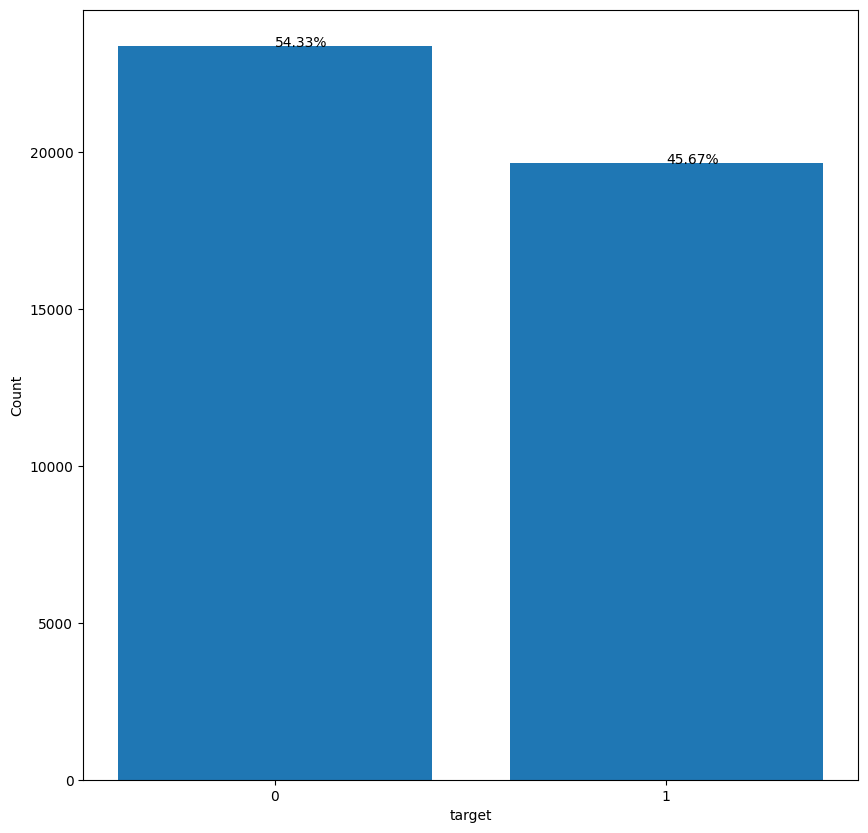

In [ ]:
plot_histogram_with_percentage(df2,'target')

In [ ]:
new_df = pd.DataFrame({'text': df_org['text'], 'cleaned_text': df2['text'], 'target': df['target']})

new_df

,text,cleaned_text,target
0,ANKARA (Reuters) - Turkish and Sudanese intell...,ankara reuters turkish sudanese intelligence a...,Real
1,(Reuters) - The U.S. Supreme Court on Friday r...,reuters supreme court friday refused stay ruli...,Real
2,If there s one presidential candidate who is t...,one presidential candidate king dog whistle po...,Fake
3,No wonder she didn t want anyone to see her sp...,wonder want anyone see speech singing praise t...,Fake
4,Feel the Bern of a lot of gullible young peopl...,feel bern lot gullible young people fed big li...,Fake
...,...,...,...
43050,WASHINGTON (Reuters) - Democratic presidential...,washington reuters democratic presidential nom...,Real
43051,VATICAN CITY/WASHINGTON (Reuters) - U.S. Democ...,vatican city washington reuters democratic pre...,Real
43052,"Last week, after the New York Giants player Od...",last week new york giant player odell beckham ...,Fake
43053,ALMATY (Reuters) - Kazakhstan is to change its...,almaty reuters kazakhstan change official alph...,Real


In [ ]:
df_org.target.value_counts()

Real    23362
Fake    19693
Name: target, dtype: int64

In [ ]:
df_cleaned = df2

In [ ]:
df_cleaned.target.value_counts()

0    23362
1    19636
Name: target, dtype: int64

In [ ]:
pip install pyspellchecker


In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()

In [ ]:
import re

def spell_check_text(text):
    # Tokenize the text into words
    words = re.findall(r'\b\w+\b', text)

    # Perform spell check and get misspelled words
    misspelled = spell.unknown(words)

    # Replace misspelled words with corrected spellings
    corrected_text = " ".join(spell.correction(word) if word in misspelled else word for word in words)

    return corrected_text

# Example usage on a single text
#original_text = "Thiss is an examplee sentance with somme misspelled wordds."
#corrected_text = spell_check_text(original_text)

#print("Original Text:", original_text)
#print("Corrected Text:", corrected_text)

In [ ]:
df_cleaned['text'].info()

<class 'pandas.core.series.Series'>
Int64Index: 42998 entries, 0 to 43054
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
42998 non-null  object
dtypes: object(1)
memory usage: 1.7+ MB


In [ ]:
# Assuming df is your DataFrame with a 'text' column
#df_cleaned['text_withspellcheck'] = df_cleaned['text'].apply(spell_check_text)

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42998 entries, 0 to 43054
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    42998 non-null  object
 1   target  42998 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


In [ ]:
# Cleaned Dataset into file
#----------------- Save merged dataset to CSV -----------------
from google.colab import files

## Use this to save dataset to CSV
df2.to_csv('CleanedData.csv', index=False)
files.download('CleanedData.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
### data cleaning end